Nour Mansour and Juan Estrella

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns

Part 1: Data Collection

Step 1: Get the tsv data

In [2]:
# Data is saved in the same folder as the project. Then read data from tsv file
data = pd.read_csv("train-balanced-sarcasm.csv")

Part 2: Data Processing

Step 1: Columns required: Label, Comments, subreddit, parent comment

Step 2: Create a Dataframe containing an even amount of sarcastic and non sarcastic 
comments, amount of data is 505413 each. 

In [3]:
# Reset the indices after rows with NA values are dropped
data.dropna(inplace=True)
data.drop(['author', 'score', 'ups', 'downs', 'date', 'created_utc', 'subreddit', 'parent_comment'], axis = 1, inplace = True)
data.reset_index(inplace = True)
data.drop(['index'], axis = 1, inplace = True)
data.head()

,label,comment
0,0,NC and NH.
1,0,You do know west teams play against west teams...
2,0,"They were underdogs earlier today, but since G..."
3,0,"This meme isn't funny none of the ""new york ni..."
4,0,I could use one of those tools.


In [5]:
#data.groupby('label').describe()

We really wanted to use the entire dataset, unfortunately our laptops weren't strong enough to perform the different types of data manipulation and analysis we wanted. 
As a solution, we decided to sample 10% of the dataset each time we ran the program. 10% was actually the largest sample we could get without our Jupyter kernel dying from overflowing Docker's allocated memory resources (we set the memory for Docker to the max value possible given our laptops' specs!). 

In [4]:
data.drop(data[data.comment =='You forgot the'].index, inplace=True)
data.drop(data[data.comment =='you forgot the'].index, inplace=True)
data.drop(data[data.comment =='you dropped this:'].index, inplace=True)
data.drop(data[data.comment =='You dropped this:'].index, inplace=True)
data.drop(data[data.comment =='Forgot the'].index, inplace=True)
data.drop(data[data.comment =='You forgot'].index, inplace=True)
data.drop(data[data.comment =='You forgot your'].index, inplace=True)
data.drop(data[data.comment =='You dropped this'].index, inplace=True)
data.drop(data[data.comment =='I think you forgot the'].index, inplace=True)
data.drop(data[data.comment =='You forgot this:'].index, inplace=True)
data.drop(data[data.comment =='You dropped your'].index, inplace=True)
data.drop(data[data.comment =='I forgot the'].index, inplace=True)
data.drop(data[data.comment =='you forgot'].index, inplace=True)

In [5]:
# Determine size and replacement values
size = int(len(data)*2.5/100)# sample size
replace = True  # with replacement
# Function used to pick random rows from the dataset
# We used the groupby('label') function to choose equal numbers 
# of sarcastic and non-sarcastic comments
fun = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
chosen_data = data.groupby('label', as_index=False).apply(fun)
chosen_data.head()

label                                            comment
0 429141       0  sooo you're on a destiny reddit talking about ...
  405462       0  "Hey, if little Joey's dead, then I got no rea...
  545778       0                                      Scandinavian?
  773429       0    That doesn't sound very supportive on his part.
  1004209      0  Why the hell YouTube results contain these vid...

In [6]:
# Reset the indexes to remove the grouping into 0s and 1s
chosen_data.reset_index(inplace = True)
# Delete the columns that include the names of the indexes created from the groups
chosen_data.drop(['level_0', 'level_1'], inplace = True, axis = 1)
chosen_data.head()

,label,comment
0,0,sooo you're on a destiny reddit talking about ...
1,0,"""Hey, if little Joey's dead, then I got no rea..."
2,0,Scandinavian?
3,0,That doesn't sound very supportive on his part.
4,0,Why the hell YouTube results contain these vid...


In [7]:
chosen_data.tail()

,label,comment
50325,1,But she's his *~mommy~* wiiiiife!
50326,1,Both are almost never reported because we woul...
50327,1,But there is a link between video games and mi...
50328,1,Because creationism is defensible.
50329,1,"here, i think you dropped this:"


Part 3: Exploratory Analysis & Data Visualization

We made sure we got equal number of sarcastic and non-sarcastic comments. From the following histogram, we notice we got 50,000 comments from each group.

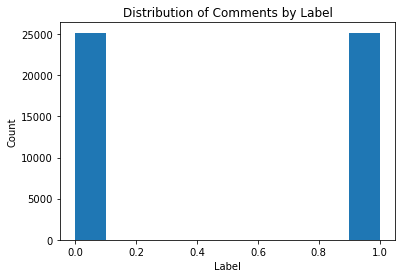

In [8]:
# Explore distribution of the data by label (0 -> non-sarcastic, 1 -> sarcastic)
plt.hist(chosen_data.label)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Comments by Label')
plt.show()

In [9]:
# Explore distribution of comments by label 
chosen_data.groupby('label').describe()

comment                           
        count unique            top freq
label                                   
0       25165  24068           Yes.   21
1       25165  24374  He forgot the    7

In [10]:
#Import NLTK library
!pip install nltk

In [11]:
import nltk

In [15]:
# nltk.download("all")

In [16]:
from nltk.corpus import stopwords #Use this to get rid of meaningless words like "the, and, a"
from nltk.tokenize import word_tokenize #Split by word
from nltk.tokenize import sent_tokenize #Split by sentence

In [17]:
#Make sure all the comment column is str data type
chosen_data['comment'] = chosen_data['comment'].astype(str)
chosen_data['comment'] = chosen_data['comment'].astype(str)

#non_sarcastic = required_data.loc[required_data['label'] == 0]
#sarcastic = required_data.loc[required_data['label'] == 1]

#drop rows with na values on the comment column
#non_sarcastic['comment'].dropna(inplace=True)
#sarcastic['comment'].dropna(inplace=True)

#Make sure all the comment column is str data type
#non_sarcastic['comment'] = non_sarcastic['comment'].astype(str)
#sarcastic['comment'] = sarcastic['comment'].astype(str)
#print(len(non_sarcastic), len(sarcastic))

In [18]:
# Split the comments into words
chosen_data['tok_comment'] = chosen_data['comment'].apply(word_tokenize)
# Apply Parts of Speech tagging on the words
chosen_data['POS_tag'] = chosen_data['tok_comment'].apply(nltk.pos_tag)
chosen_data.head()

,label,comment,tok_comment,POS_tag
0,0,sooo you're on a destiny reddit talking about ...,"[sooo, you, 're, on, a, destiny, reddit, talki...","[(sooo, NN), (you, PRP), ('re, VBP), (on, IN),..."
1,0,"""Hey, if little Joey's dead, then I got no rea...","[``, Hey, ,, if, little, Joey, 's, dead, ,, th...","[(``, ``), (Hey, NNP), (,, ,), (if, IN), (litt..."
2,0,Scandinavian?,"[Scandinavian, ?]","[(Scandinavian, JJ), (?, .)]"
3,0,That doesn't sound very supportive on his part.,"[That, does, n't, sound, very, supportive, on,...","[(That, DT), (does, VBZ), (n't, RB), (sound, V..."
4,0,Why the hell YouTube results contain these vid...,"[Why, the, hell, YouTube, results, contain, th...","[(Why, WRB), (the, DT), (hell, NN), (YouTube, ..."


In [19]:
# Apply stemming on the tokenized comments to get the roots of the words
from nltk.stem.snowball import SnowballStemmer

stemmer = SnowballStemmer("english")

chosen_data['stem'] = chosen_data['tok_comment'].apply(lambda x: [stemmer.stem(y) for y in x])
chosen_data.head()

,label,comment,tok_comment,POS_tag,stem
0,0,sooo you're on a destiny reddit talking about ...,"[sooo, you, 're, on, a, destiny, reddit, talki...","[(sooo, NN), (you, PRP), ('re, VBP), (on, IN),...","[sooo, you, re, on, a, destini, reddit, talk, ..."
1,0,"""Hey, if little Joey's dead, then I got no rea...","[``, Hey, ,, if, little, Joey, 's, dead, ,, th...","[(``, ``), (Hey, NNP), (,, ,), (if, IN), (litt...","[``, hey, ,, if, littl, joey, 's, dead, ,, the..."
2,0,Scandinavian?,"[Scandinavian, ?]","[(Scandinavian, JJ), (?, .)]","[scandinavian, ?]"
3,0,That doesn't sound very supportive on his part.,"[That, does, n't, sound, very, supportive, on,...","[(That, DT), (does, VBZ), (n't, RB), (sound, V...","[that, doe, n't, sound, veri, support, on, his..."
4,0,Why the hell YouTube results contain these vid...,"[Why, the, hell, YouTube, results, contain, th...","[(Why, WRB), (the, DT), (hell, NN), (YouTube, ...","[whi, the, hell, youtub, result, contain, thes..."


After confirming our suspicions that using TF-IDF on the raw tokenized comments would yield very modest results, we decided to continue exploring how we can fix our models. First, we used chunking to break up the comments into more meaningful noun phrases. 

In [19]:
# Use reg ex to chunk the sentences into noun phrases
# np_chunking = "NP: {<DT>?<JJ>*<NN>}"
# chunk_parser = nltk.RegexpParser(np_chunking)
# chosen_data['noun_phrase_chunk'] = chosen_data['POS_tag'].apply(chunk_parser.parse)

Notice how the chunked sentences column groups the nouns into groups with

In [17]:
# chosen_data.iloc[0:10, 2:5:2]

In [18]:
# chosen_data.tail()

In [20]:
joined_tag = []
for index, row in chosen_data.iterrows():
    joined_tag.append(' '.join([word + "_" + pos for word, pos in row['POS_tag']]))
chosen_data['joined_POS_tag'] = joined_tag.copy()

In [21]:
chosen_data.head()

,label,comment,tok_comment,POS_tag,stem,joined_POS_tag
0,0,sooo you're on a destiny reddit talking about ...,"[sooo, you, 're, on, a, destiny, reddit, talki...","[(sooo, NN), (you, PRP), ('re, VBP), (on, IN),...","[sooo, you, re, on, a, destini, reddit, talk, ...",sooo_NN you_PRP 're_VBP on_IN a_DT destiny_JJ ...
1,0,"""Hey, if little Joey's dead, then I got no rea...","[``, Hey, ,, if, little, Joey, 's, dead, ,, th...","[(``, ``), (Hey, NNP), (,, ,), (if, IN), (litt...","[``, hey, ,, if, littl, joey, 's, dead, ,, the...","``_`` Hey_NNP ,_, if_IN little_JJ Joey_NNP 's_..."
2,0,Scandinavian?,"[Scandinavian, ?]","[(Scandinavian, JJ), (?, .)]","[scandinavian, ?]",Scandinavian_JJ ?_.
3,0,That doesn't sound very supportive on his part.,"[That, does, n't, sound, very, supportive, on,...","[(That, DT), (does, VBZ), (n't, RB), (sound, V...","[that, doe, n't, sound, veri, support, on, his...",That_DT does_VBZ n't_RB sound_VB very_RB suppo...
4,0,Why the hell YouTube results contain these vid...,"[Why, the, hell, YouTube, results, contain, th...","[(Why, WRB), (the, DT), (hell, NN), (YouTube, ...","[whi, the, hell, youtub, result, contain, thes...",Why_WRB the_DT hell_NN YouTube_NNP results_NNS...


In [27]:
# Not sure if we'll need to lemmatize the words yet

#from nltk.stem import WordNetLemmatizer
#data['lemma'] = data['tokenized_by_word'].apply(WordNetLemmatizer)
# df14.append(df24.append(df34.append(df44)))
# df14.tail()

In [22]:
!pip install -U textblob
from textblob import TextBlob

blob_list = []
for index, row in chosen_data.iterrows():
    blob_list.append(TextBlob(row['comment']))
chosen_data['textblob'] = blob_list.copy()

chosen_data.head()

polarity_list = []
for index, row in chosen_data.iterrows():
    polarity_list.append(row['textblob'].sentiment.polarity)

chosen_data['polarity'] = polarity_list.copy()

chosen_data.head()

print(chosen_data['polarity'].shape)

Requirement already up-to-date: textblob in /opt/conda/lib/python3.7/site-packages (0.15.3)
(50330,)


### Predicting Sarcasm

We were interested in trying different models for predicting a sarcastic comment.
To determine the features and labels for the analysis, we decided to look at the comment itself as a feature and use the given sarcastic vs non-sarcastic classification as our label.

Various articles and studies looked at sarcasm and attempted to predict using different features. For instance, an online tutorial only looked at TF-IDF as a feature, so we decided we wanted to experiment with that and see if we would get anything remotely close to their findings. Worth noting, however, that they looked at tweets with the #sarcasm tag, their dataset was significantly smaller than ours (N= ), and their training vs test data split was slightly unusual (training = 95%, test = 5%). 

To create a more reliable model, we decided to split our data into the more common 80-20 split for training and test subsets respectively. We also chose three main models to compare, acknowledging that some of them might fare slightly more poorly compared to the others. We also assumed TF-IDF vectorization of the comments alone would not be a good predictor for whether a comment is sarcastic or not. 

The three models we picked were:
1. Logistic regression
2. Support Vector Machine
3. Random forest

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [24]:
# features
chosen_data['joined_stem'] = chosen_data['stem'].apply(lambda x: ' '.join(x))
chosen_data.head()

,label,comment,tok_comment,POS_tag,stem,joined_POS_tag,textblob,polarity,joined_stem
0,0,sooo you're on a destiny reddit talking about ...,"[sooo, you, 're, on, a, destiny, reddit, talki...","[(sooo, NN), (you, PRP), ('re, VBP), (on, IN),...","[sooo, you, re, on, a, destini, reddit, talk, ...",sooo_NN you_PRP 're_VBP on_IN a_DT destiny_JJ ...,"(s, o, o, o, , y, o, u, ', r, e, , o, n, , ...",0.000000,sooo you re on a destini reddit talk about fal...
1,0,"""Hey, if little Joey's dead, then I got no rea...","[``, Hey, ,, if, little, Joey, 's, dead, ,, th...","[(``, ``), (Hey, NNP), (,, ,), (if, IN), (litt...","[``, hey, ,, if, littl, joey, 's, dead, ,, the...","``_`` Hey_NNP ,_, if_IN little_JJ Joey_NNP 's_...","("", H, e, y, ,, , i, f, , l, i, t, t, l, e, ...",-0.083712,"`` hey , if littl joey 's dead , then i got no..."
2,0,Scandinavian?,"[Scandinavian, ?]","[(Scandinavian, JJ), (?, .)]","[scandinavian, ?]",Scandinavian_JJ ?_.,"(S, c, a, n, d, i, n, a, v, i, a, n, ?)",0.000000,scandinavian ?
3,0,That doesn't sound very supportive on his part.,"[That, does, n't, sound, very, supportive, on,...","[(That, DT), (does, VBZ), (n't, RB), (sound, V...","[that, doe, n't, sound, veri, support, on, his...",That_DT does_VBZ n't_RB sound_VB very_RB suppo...,"(T, h, a, t, , d, o, e, s, n, ', t, , s, o, ...",0.525000,that doe n't sound veri support on his part .
4,0,Why the hell YouTube results contain these vid...,"[Why, the, hell, YouTube, results, contain, th...","[(Why, WRB), (the, DT), (hell, NN), (YouTube, ...","[whi, the, hell, youtub, result, contain, thes...",Why_WRB the_DT hell_NN YouTube_NNP results_NNS...,"(W, h, y, , t, h, e, , h, e, l, l, , Y, o, ...",0.000000,whi the hell youtub result contain these video...


In [25]:
X_train, X_test, y_train, y_test = train_test_split(chosen_data[['joined_POS_tag', 'joined_stem']] , chosen_data.label, test_size=0.2, random_state=0)

In [26]:
X_train.head()

,joined_POS_tag,joined_stem
7756,Is_VBZ this_DT the_DT Cable_JJ with_IN full_JJ...,is this the cabl with full use of his psionic ...
30313,I_PRP honestly_RB do_VBP n't_RB get_VB it_PRP !_.,i honest do n't get it !
11299,Has_NNP n't_RB closed_VBD yet_RB,has n't close yet
25645,"Yeah_UH ,_, the_DT people_NNS that_WDT are_VBP...","yeah , the peopl that are upset at have their ..."
30009,u/junior312_NN is_VBZ the_DT girl_NN on_IN the...,u/junior312 is the girl on the right


In [37]:
# TF-IDF to vectorize the data
import scipy.sparse as sp
from sklearn.feature_extraction.text import TfidfVectorizer
stem_vectorizer = TfidfVectorizer(ngram_range = (1,3)) # ask about max features
tfidf_stem = stem_vectorizer.fit_transform(X_train.joined_stem)

pos_vectorizer = TfidfVectorizer(ngram_range = (1,3))
tfidf_pos = pos_vectorizer.fit_transform(X_train.joined_POS_tag)

combined_2 = sp.hstack([tfidf_stem, tfidf_pos], format = 'csr')

In [38]:
print(tfidf_stem.shape)
print(tfidf_pos.shape)
print(combined_2.shape)

(40264, 463819)
(40264, 539072)
(40264, 1002891)


In [39]:
print(combined_2)

  (0, 68926)	0.17464625294469144
  (0, 68961)	0.2261560635942137
  (0, 68962)	0.2261560635942137
  (0, 137219)	0.14043789532410667
  (0, 137389)	0.2261560635942137
  (0, 137390)	0.2261560635942137
  (0, 167961)	0.100556058244647
  (0, 168860)	0.2261560635942137
  (0, 168861)	0.2261560635942137
  (0, 186577)	0.0602433756178877
  (0, 191822)	0.14527178836940863
  (0, 191876)	0.18901455125720107
  (0, 260509)	0.06322171593365364
  (0, 262483)	0.15399318462147402
  (0, 262526)	0.2261560635942137
  (0, 294804)	0.134557595290609
  (0, 299969)	0.21775114788222044
  (0, 299970)	0.2261560635942137
  (0, 365115)	0.04626843014667722
  (0, 367063)	0.21775114788222044
  (0, 367065)	0.2261560635942137
  (0, 389500)	0.0747193215890801
  (0, 391474)	0.1817944764623401
  (0, 391477)	0.2261560635942137
  (0, 417015)	0.10033925016189488
  :	:
  (40262, 781821)	0.15875025231707407
  (40262, 832857)	0.14140081028366594
  (40262, 832862)	0.17966043470029677
  (40262, 832866)	0.19613276671264013
  (40262, 84

In [33]:
combined_3 = sp.hstack((combined_2,np.array(chosen_data.polarity)[:,None]))

ValueError: blocks[0,:] has incompatible row dimensions. Got blocks[0,1].shape[0] == 50330, expected 40264.

In [69]:
# test_stem_vectorizer = TfidfVectorizer(max_features = 10000) # ask about max features
test_tfidf_stem = stem_vectorizer.transform(X_test.joined_stem)

# test_pos_vectorizer = TfidfVectorizer(max_features = 10000)
test_tfidf_pos = pos_vectorizer.transform(X_test.joined_POS_tag)

test_combined_2 = sp.hstack([test_tfidf_stem, test_tfidf_pos], format = 'csr')


In [70]:
test_combined_2.shape

(4027, 454979)

In [71]:
# Logistic Regression

log_clf = LogisticRegression(solver='lbfgs', max_iter = 300).fit(combined_2, y_train)

In [72]:
# Logistic regression score
print(log_clf.score(combined_2, y_train))
print(log_clf.score(test_combined_2, y_test))

0.9802545793231916
0.6776756890985846


In [73]:
# SVM model
svm_clf = LinearSVC()

# Training the model
svm_clf.fit(combined_2, y_train)

print(svm_clf.score(combined_2, y_train))
print(svm_clf.score(test_combined_2, y_test))

0.9967711890717169
0.6687360317854483


In [74]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators = 100)

rf_clf.fit(combined_2, y_train)

print(rf_clf.score(combined_2, y_train))
print(rf_clf.score(test_combined_2, y_test))

0.9970195591431232
0.6530916314874596


In [91]:
# Determine the features and labels for the models
# features = chosen_data['stem'].apply(lambda x: ' '.join(x))
# labels = chosen_data['label']

In [ ]:

# tfidf_train_x = vectorizer.fit_transform(X_train)
# print(vectorizer.fit_transform(chosen_data['joined_stem']).toarray().shape)

# The dimensions from the tfidf vectorization doesn't fit the dataframe
# I'm not sure how to include both features in the model

# chosen_data['tfidf_stem'] = vectorizer.fit_transform(chosen_data['joined_stem']).toarray()
# chosen_data['tfidf_pos'] = vectorizer.fit_transform(chosen_data['joined_POS_tag']).toarray()
# chosen_data.head()
# features = list(features)
# X = vectorizer.fit_transform(features)

We vectorized the comments here and used the TF-IDF list as the feature in our model.

In [ ]:
X = chosen_data[['tfidf_stem', 'tfidf_pos']].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, chosen_data.label, test_size=0.2, random_state=0)

In [48]:
print(x1.todense())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [49]:
#print(vectorizer.get_feature_names())
# print(X.shape)
x2 = vectorizer.fit_transform(chosen_data['joined_POS_tag'])

In [46]:
# print(x1)
# print(x2)
# print(x1.shape)
# print(x2.shape)
# print(x1.toarray())
# print(list(x2))

In [50]:
# d = {'stem': x1.toarray(), 'pos': list(x2)}

X = [x1, x2].as_matrix()
X

AttributeError: 'list' object has no attribute 'as_matrix'

In [31]:
from sklearn.pipeline import FeatureUnion

estimators = [('tfidf', TfidfVectorizer())]
combined = FeatureUnion(estimators)
combined
# features = chosen_data.iloc[:, 3:6:2]


In [63]:
features = chosen_data.iloc[:, 5:7]
features.head()

,joined_POS_tag,joined_stem
0,"Oh_UH ,_, they_PRP do_VBP ._.","oh , they do ."
1,makes_VBZ it_PRP way_NN to_TO much_JJ red_JJ a...,make it way to much red and yellow imo
2,Um_NN ..._: What_WP ?_.,um ... what ?
3,For_IN select_JJ teams_NNS :_: 49ers_CD somewh...,for select team : 49er somewher in the top 4 r...
4,If_IN you_PRP make_VBP coffee_NN often_RB you_...,if you make coffe often you alreadi have all t...


In [66]:
combined.fit_transform(features).shape

(2, 2)

In [60]:
combined.fit_transform(features)

<2x2 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [61]:
X = combined.fit_transform(features)
print(X)

  (0, 0)	1.0
  (1, 1)	1.0


In [ ]:
# Split data into Training and Test data chosen_data[['comment', 'POS_tag', 'stem']]

X_train, X_test, y_train, y_test = train_test_split(X, chosen_data.label, test_size=0.2, random_state=0)

In [ ]:
#print(X)
# X.toarray() # it only works if it's an array but why does it become all 0s?
X = chosen_data.iloc[:, 3:6:2]
X
# chosen_data.iloc[:, 3:6:2]
# print(chosen_data.iloc[0, 3])
X['stem'] = X['stem'].apply(lambda x: x.toarray())
X

In [99]:
#print(X)

In [39]:
chosen_data.head()

,label,comment,POS_tag,stem,noun_phrase_chunk,joined_POS_tag
0,0,"[How, 's, his, wife, ?]","[(How, WRB), ('s, VBZ), (his, PRP$), (wife, NN...","[how, 's, his, wife, ?]","[(How, WRB), ('s, VBZ), (his, PRP$), [(wife, N...",How_WRB 's_VBZ his_PRP$ wife_NN ?_.
1,0,"[And, let, Artemis, traps, act, like, springs,...","[(And, CC), (let, VB), (Artemis, NNP), (traps,...","[and, let, artemi, trap, act, like, spring, wh...","[(And, CC), (let, VB), (Artemis, NNP), (traps,...",And_CC let_VB Artemis_NNP traps_VB act_NN like...
2,0,"[my, first, thought, :, ``, Why, is, a, wookie...","[(my, PRP$), (first, JJ), (thought, NN), (:, :...","[my, first, thought, :, ``, whi, is, a, wooki,...","[(my, PRP$), [(first, JJ), (thought, NN)], (:,...",my_PRP$ first_JJ thought_NN :_: ``_`` Why_WRB ...
3,0,"[In, my, experience, the, people, who, make, t...","[(In, IN), (my, PRP$), (experience, NN), (the,...","[in, my, experi, the, peopl, who, make, those,...","[(In, IN), (my, PRP$), [(experience, NN)], (th...",In_IN my_PRP$ experience_NN the_DT people_NNS ...
4,0,"[Could, n't, find, it, I, guess, ?]","[(Could, MD), (n't, RB), (find, VB), (it, PRP)...","[could, n't, find, it, i, guess, ?]","[(Could, MD), (n't, RB), (find, VB), (it, PRP)...",Could_MD n't_RB find_VB it_PRP I_PRP guess_RB ?_.


In [115]:
# Split data into Training and Test data chosen_data[['comment', 'POS_tag', 'stem']]

X_train, X_test, y_train, y_test = train_test_split(X, chosen_data.label, test_size=0.2, random_state=0)

In [64]:
# Logistic Regression

log_clf = LogisticRegression(solver='lbfgs', max_iter = 300).fit(X_train, y_train)

In [65]:
# Predict the test values

log_clf.predict(X_test)

array([0, 0, 0, ..., 0, 0, 0])

In [66]:
# Logistic regression score
print(log_clf.score(X_train, y_train))
print(log_clf.score(X_test, y_test))

0.5003711952487008
0.49851632047477745


In [67]:
# SVM model

svm_clf = LinearSVC()

In [68]:
# Training the model

svm_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [69]:
print(svm_clf.score(X_train, y_train))
print(svm_clf.score(X_test, y_test))

0.5003711952487008
0.49851632047477745


In [70]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators = 10)

In [71]:
rf_clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [72]:
print("training score: ", rf_clf.score(X_train, y_train))
print("test score: ", rf_clf.score(X_test, y_test))

training score:  0.5003711952487008
test score:  0.5024727992087042


In [53]:
features2 = chosen_data['joined_POS_tag']
#features2

In [54]:
features2 = list(features2)
X2 = vectorizer.fit_transform(features2)

In [55]:
X2

<151614x95627 sparse matrix of type '<class 'numpy.float64'>'
	with 1564163 stored elements in Compressed Sparse Row format>

In [1]:
print(X2, "\n")
print(X2.toarray(), "\n")
print(X2)

NameError: name 'X2' is not defined

In [44]:
# Split data into Training and Test data chosen_data[['comment', 'POS_tag', 'stem']]

X_train, X_test, y_train, y_test = train_test_split(X2, chosen_data.label, test_size=0.2, random_state=0)

In [46]:
# Logistic Regression

log_clf = LogisticRegression(solver='lbfgs', max_iter = 300).fit(X_train, y_train)

In [47]:
# Logistic regression score
print(log_clf.score(X_train, y_train))
print(log_clf.score(X_test, y_test))

0.7819541433412207
0.6916861788081654


In [48]:
# SVM model
svm_clf = LinearSVC()

# Training the model
svm_clf.fit(X_train, y_train)

print(svm_clf.score(X_train, y_train))
print(svm_clf.score(X_test, y_test))

0.8720515124782547
0.6900702437093955


In [49]:
# Random Forest Classifier

rf_clf = RandomForestClassifier(n_estimators = 10)

rf_clf.fit(X_train, y_train)

print(rf_clf.score(X_train, y_train))
print(rf_clf.score(X_test, y_test))

0.980196387201029
0.6772746759885235
